# Intro to Argovis' CCHDO API

Argovis indexes a subset of CCHDO data. In this notebook, we tour basic search and colocation options for this dataset.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages and declaring a couple of helper functions, make sure to plug in your Argovis API key for `API_KEY` at the bottom of the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import datetime, time, json, requests, pprint, copy
from argovisHelpers import helpers as avh

def polygon_lon_lat(polygon_str):
    # polygon_str: string value of polygon search parameter, ie "[[lon0,lat0],[lon1,lat1],...,[lon0,lat0]]"
    # convert the polygon shape to lon and lat and save in a dictionary
    polygon_lon_lat_dict = {'lon': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[0::2]], \
                    'lat': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[1::2]]
                   }
    return polygon_lon_lat_dict

def simple_map(longitudes, latitudes, z=None, polygon=None, title='', fig=None, figIndex=None, marker=None, secondaries=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal(cutoff=-60))
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(cutoff=-60))
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        plt.colorbar(s, pad=0.1)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    
    if polygon:
        plt.plot(polygon_lon_lat(polygon)['lon'],polygon_lon_lat(polygon)['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color='red', marker='x', s=100)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':20})

API_KEY=''
API_PREFIX='https://argovis-api.colorado.edu/'

## Finding Available WOCE Lines & Cruises

In order to browse what cruises and WOCE lines Argovis has available for CCHDO data, we provide a vocabulary route that summarizes what's available in the database:

In [2]:
vocab_params = {
    "parameter": "woceline" # could also be "cchdo_cruise"
}

wocelines = avh.query('cchdo/vocabulary', options=vocab_params, apikey=API_KEY, apiroot=API_PREFIX)
wocelines

[None,
 '06MT19920316',
 '06MT19920509',
 '06MT19920701',
 '06MT19960613',
 '06MT19960910',
 '160W',
 '26AA0009',
 '32EV19910328',
 '40N',
 '75N',
 'A01',
 'A01E',
 'A02',
 'A03',
 'A05',
 'A06',
 'A07',
 'A07  ',
 'A08',
 'A09',
 'A09.5',
 'A095',
 'A10',
 'A11',
 'A12',
 'A13',
 'A13.5',
 'A14',
 'A15/AR15',
 'A16C',
 'A16N',
 'A16N/AR21',
 'A16S',
 'A17',
 'A20',
 'A21',
 'A22',
 'A23',
 'A24',
 'A25',
 'A9.5',
 'AAIW05',
 'AAIW06',
 'ACT2010',
 'AJAX',
 'ALIZE',
 'ANA',
 'ANAS1',
 'ANAS2',
 'ANAS3',
 'ANAS4',
 'ANAS6',
 'ANAS7',
 'ANDREX',
 'ANT-V_2',
 'ANTX_6',
 'AO-01',
 'AO94',
 'AO95',
 'AR01',
 'AR02',
 'AR03',
 'AR04',
 'AR04EW',
 'AR04EW/AR15',
 'AR05/AR07W',
 'AR06/AR16',
 'AR07',
 'AR07E',
 'AR07E/AR12',
 'AR07E/AR25',
 'AR07W',
 'AR07W/AR13',
 'AR07W/AR13/AR27',
 'AR08',
 'AR09',
 'AR10',
 'AR11',
 'AR12',
 'AR12/AR24',
 'AR13',
 'AR15',
 'AR16',
 'AR18',
 'AR19',
 'AR21',
 'AR24',
 'AR25',
 'AR26',
 'AR27',
 'AR28',
 'AR4E/AR4W/AR15',
 'ARC01',
 'ARK-II_3',
 'ARK-IV_3',


We can then download all the data from a given WOCE line:

In [3]:
cchdo_params = {
    "woceline": "A10" # or anything from the list above
}

cchdo = avh.query('cchdo', options=cchdo_params, apikey=API_KEY, apiroot=API_PREFIX)
cchdo[0]

{'_id': 'expo_740H20180228_sta_125_cast_001',
 'metadata': '2130_m1',
 'geolocation': {'coordinates': [13.53106, -23.12932], 'type': 'Point'},
 'basin': 1,
 'timestamp': '2018-04-06T06:52:00.000Z',
 'source': [{'data_keys_source': ['sample',
    'pressure',
    'pressure_qc',
    'ctd_temperature',
    'ctd_temperature_qc',
    'ctd_salinity',
    'ctd_salinity_qc',
    'ctd_oxygen',
    'ctd_oxygen_qc'],
   'data_source_standard_names': {'time': 'time',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'btm_depth': 'sea_floor_depth_below_sea_surface',
    'pressure': 'sea_water_pressure',
    'pressure_qc': 'status_flag',
    'ctd_temperature': 'sea_water_temperature',
    'ctd_temperature_qc': 'status_flag',
    'ctd_salinity': 'sea_water_practical_salinity',
    'ctd_salinity_qc': 'status_flag',
    'ctd_oxygen': 'moles_of_oxygen_per_unit_mass_in_sea_water',
    'ctd_oxygen_qc': 'status_flag'},
   'data_source_reference_scale': {'ctd_temperature': 'ITS-90',
    'ctd_sali

Much of the metadata for CCHDO documents live in their own collection, referenced by the `metadata` key in each of the above hits. We can look this metadata up using the appropriate route:

In [4]:
cchdo_metadata = {
    "id": cchdo[0]['metadata']
}

cchdo_meta = avh.query('cchdo/meta', options=cchdo_metadata, apikey=API_KEY, apiroot=API_PREFIX)
cchdo_meta

[{'_id': '2130_m1',
  'date_updated_argovis': '2022-09-04T04:53:17.867Z',
  'data_type': 'oceanicProfile',
  'country': '74',
  'data_center': 'CCHDO',
  'instrument': 'ship_ctd',
  'pi_name': ['Brian King'],
  'expocode': '740H20180228',
  'woce_lines': ['A9.5', 'A10', 'A095', 'A09.5', 'A09'],
  'cchdo_cruise_id': 2130}]

Note that the metadata pointer, in this case `1116_m0`, encodes the CCHDO cruise ID as its first token, 1116 in this case. We can get the measurements for this WOCE line and cruise as follows; this time, let's also ask for the CTD measurement of salinity:

In [5]:
cruise_params = {
    "cchdo_cruise": 1116,
    "woceline": "A10",
    "data": 'salinity_ctd'
}

cruise = avh.query('cchdo', options=cruise_params, apikey=API_KEY, apiroot=API_PREFIX)

We can then plot this cruise, colored by surface salinity, as per:

/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


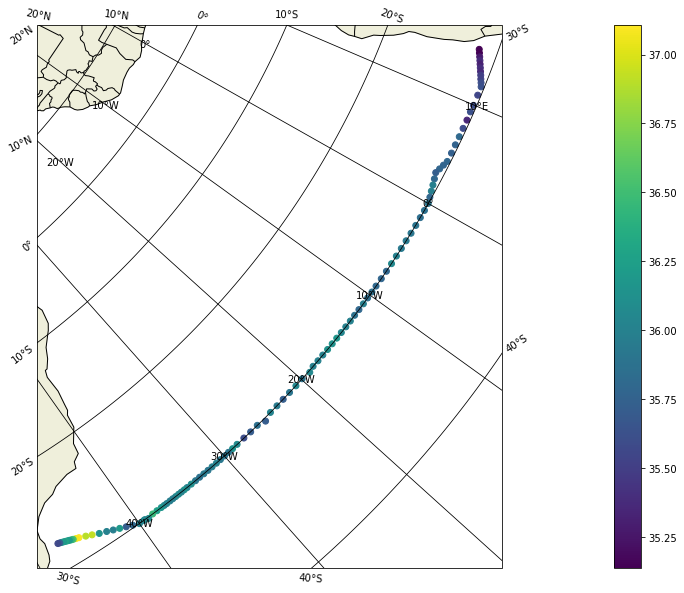

In [6]:
cchdo_longitudes = [x['geolocation']['coordinates'][0] for x in cruise]
cchdo_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise]
ctd_salinity = [x['data'][0]['salinity_ctd'] for x in cruise]

simple_map(cchdo_longitudes,cchdo_latitudes,ctd_salinity)

## Co-locating with CCHDO

Now that we've found some CCHDO data of interest, we can go looking for co-located data from other data products indexed by Argovis. To do so, we can loop through every CCHDO measurement of interest and see if there are any Global Drifter Program drifters nearby in space and time.

In [7]:
colo_drifters = []
for cchdo_meas in cruise:
    drifter_param = {
        "center": str(cchdo_meas['geolocation']['coordinates'][0]) + ',' + str(cchdo_meas['geolocation']['coordinates'][1]),
        "radius": 50,
        "startDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + datetime.timedelta(minutes=-90))),
        "endDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + datetime.timedelta(minutes=+90)))
    }

    prox = avh.query('drifters', options=drifter_param, apikey=API_KEY, apiroot=API_PREFIX)
    
    if len(prox) != 0:
        colo_drifters.append(prox)
    

We can then extract longitudes and latitudes and mark the co-located drifter measurements along our traversal of A10, red X in the plot:

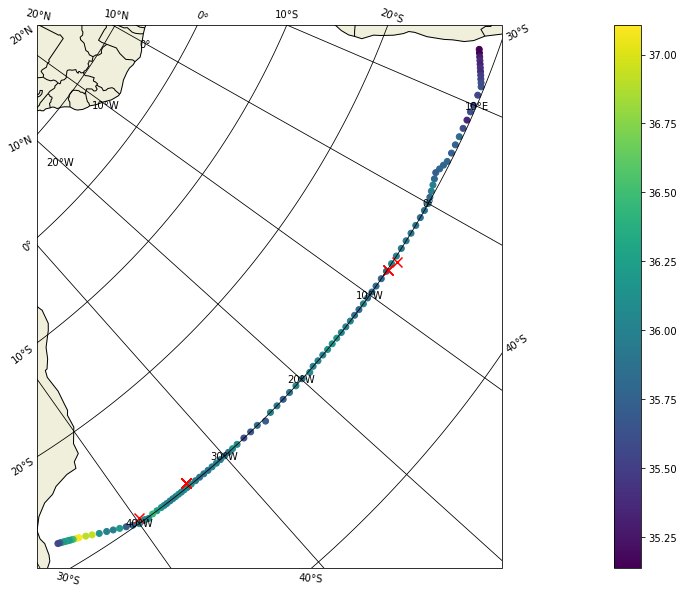

In [8]:
drifter_paths = []

for colo in colo_drifters:
    drifter_paths.append({
        "lon": [x['geolocation']['coordinates'][0] for x in colo],
        "lat": [x['geolocation']['coordinates'][1] for x in colo]
    })
simple_map(cchdo_longitudes,cchdo_latitudes,ctd_salinity, secondaries=drifter_paths)